<a href="https://colab.research.google.com/github/BrunoASNascimento/predict_frame/blob/master/predict_frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.4MB 3.4MB/s 
     |████████████████████████████████| 112kB 17.4MB/s 
     |████████████████████████████████| 460kB 10.8MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=6064606a0e87155e1e218634c3c2caee3fb84e9ef63ac33b7fa2198de7048271
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=1b405a5fd695d89bef255c648aadd29fa1323c75122f22c84b9b85e05ba261a2
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=a026

In [ ]:
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
from keras import backend as K

import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure

Using TensorFlow backend.


In [ ]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

#Active TPU

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

#Active GPU


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
#initialize wandb and download dataset

hyperparams = {"num_epochs": 10, 
          "batch_size": 32,
          "height": 96,
          "width": 96}

wandb.init(config=hyperparams)
config = wandb.config

val_dir = 'catz/test'
train_dir = 'catz/train'

# automatically get the data if it doesn't exist
if not os.path.exists("catz"):
    print("Downloading catz dataset...")
    subprocess.check_output(
        "curl https://storage.googleapis.com/wandb/catz.tar.gz | tar xz", shell=True)

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# generator to loop over train and test images

def my_generator(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cat_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, config.width, config.height, 3 * 5))
        output_images = np.zeros((batch_size, config.width, config.height, 3))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/cat_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cat_dirs[counter + i] + "/cat_result.jpg"))
            input_images[i] /= 255.
            output_images[i] /= 255.
        yield (input_images, output_images)
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size

In [ ]:
#callback to log the images

class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator(20, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)

In [ ]:
# Test the generator
gen = my_generator(2, train_dir)
videos, next_frame = next(gen)
videos[0].shape
next_frame[0].shape

(96, 96, 3)

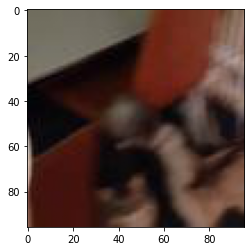

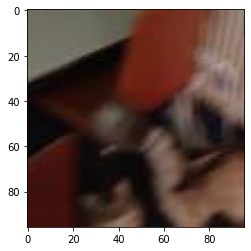

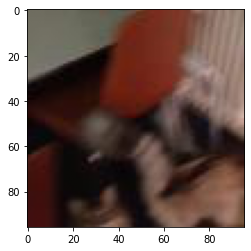

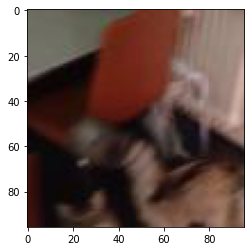

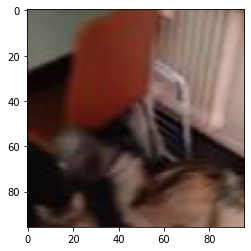

In [ ]:
figure()
imshow(videos[0][:,:,0:3])
figure()
imshow(videos[0][:,:,3:6])
figure()
imshow(videos[0][:,:,6:9])
figure()
imshow(videos[0][:,:,9:12])

figure()
imshow(next_frame[0][:,:,0:3])

In [ ]:
# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

#Test 1


In [ ]:
wandb.init(config=hyperparams)
config = wandb.config

model = Sequential()
model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(config.height, config.width, 5 * 3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

Epoch 1/10
52/52 [==============================] - 15s 294ms/step - loss: 0.1212 - perceptual_distance: 245.6347 - val_loss: 0.0408 - val_perceptual_distance: 138.8518
Epoch 2/10
52/52 [==============================] - 14s 278ms/step - loss: 0.0280 - perceptual_distance: 96.7579 - val_loss: 0.0211 - val_perceptual_distance: 75.6368
Epoch 3/10
52/52 [==============================] - 14s 277ms/step - loss: 0.0194 - perceptual_distance: 71.9720 - val_loss: 0.0154 - val_perceptual_distance: 64.6959
Epoch 4/10
52/52 [==============================] - 14s 277ms/step - loss: 0.0157 - perceptual_distance: 62.7362 - val_loss: 0.0180 - val_perceptual_distance: 58.5007
Epoch 5/10
52/52 [==============================] - 15s 280ms/step - loss: 0.0137 - perceptual_distance: 56.9444 - val_loss: 0.0164 - val_perceptual_distance: 52.2725
Epoch 6/10
52/52 [==============================] - 15s 284ms/step - loss: 0.0122 - perceptual_distance: 52.3730 - val_loss: 0.0086 - val_perceptual_distance: 47.5

# Test 2


In [ ]:
# Conv2DLSTM with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

c=4

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
x = Permute((4,1,2,3))(noise)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x = Dropout(0.2)(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
x = Dropout(0.2)(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = Add()([c2, x])
x = Dropout(0.2)(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
combined = concatenate([last_layer, x])
combined = Conv2D(3, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

Epoch 1/10
52/52 [==============================] - 153s 3s/step - loss: 0.2691 - perceptual_distance: 378.7124 - val_loss: 0.0914 - val_perceptual_distance: 215.4394
Epoch 2/10
52/52 [==============================] - 149s 3s/step - loss: 0.1065 - perceptual_distance: 245.4943 - val_loss: 0.0460 - val_perceptual_distance: 156.8984
Epoch 3/10
52/52 [==============================] - 148s 3s/step - loss: 0.0519 - perceptual_distance: 167.7686 - val_loss: 0.0354 - val_perceptual_distance: 134.0357
Epoch 4/10
52/52 [==============================] - 148s 3s/step - loss: 0.0288 - perceptual_distance: 118.5262 - val_loss: 0.0287 - val_perceptual_distance: 117.3095
Epoch 5/10
52/52 [==============================] - 148s 3s/step - loss: 0.0215 - perceptual_distance: 96.7970 - val_loss: 0.0179 - val_perceptual_distance: 95.1837
Epoch 6/10
52/52 [==============================] - 149s 3s/step - loss: 0.0185 - perceptual_distance: 86.9662 - val_loss: 0.0122 - val_perceptual_distance: 74.9805
Ep